# Predicting Heart Disease

In this project a model is trained to predict heart disease based on a dataset found [here](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction). The dataset includes relevant information for each patient, such as their personal information and some medical data, including whether or not they have had heart disease before.

First, the dataset is read into a pandas dataframe:

In [1]:
import pandas as pd

data = pd.read_csv('heart_disease_prediction.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


The feature of the dataset can be described as follows:

- Age: age of the patient (years)
- Sex: sex of the patient (M: Male, F: Female)
- ChestPainType: chest pain type (TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic)
- RestingBP: resting blood pressure (mm Hg)
- Cholesterol: serum cholesterol (mm/dl)
- FastingBS: fasting blood sugar (1: if FastingBS > 120 mg/dl, 0: otherwise)
- RestingECG: resting electrocardiogram results (Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria)
- MaxHR: maximum heart rate achieved (Numeric value between 60 and 202)
- ExerciseAngina: exercise-induced angina (Y: Yes, N: No)
- Oldpeak: oldpeak = ST (Numeric value measured in depression)
- ST_Slope: the slope of the peak exercise ST segment (Up: upsloping, Flat: flat, Down: downsloping)
- HeartDisease: output class (1: heart disease, 0: Normal)

## Data Exploration

In [2]:
print(data.shape)

(918, 12)


The dataset consists of 12 features and 918 observations and has no null values.

In [3]:
data.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

It can be observed that several feature are categorical (`object`). This includes `FastingBS` and `HeartDisease` which are numerically encoded.

In [4]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Based on these descriptive statistics the following statements can be made:
- the average age of patients is ~ 53 years
- the 0.0 values of the features `RestingBP` and `Cholersterol` seem unreasonable

The `Cholesterol` feature in particular has a median that is rougly 25 mm/dl higher than its mean. This indicates a left-skewed distribution with possible outliers skewing the distribution.

There are no missing values in the dataset:

In [5]:
data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

The distributions of all categorical features can be observed visually:

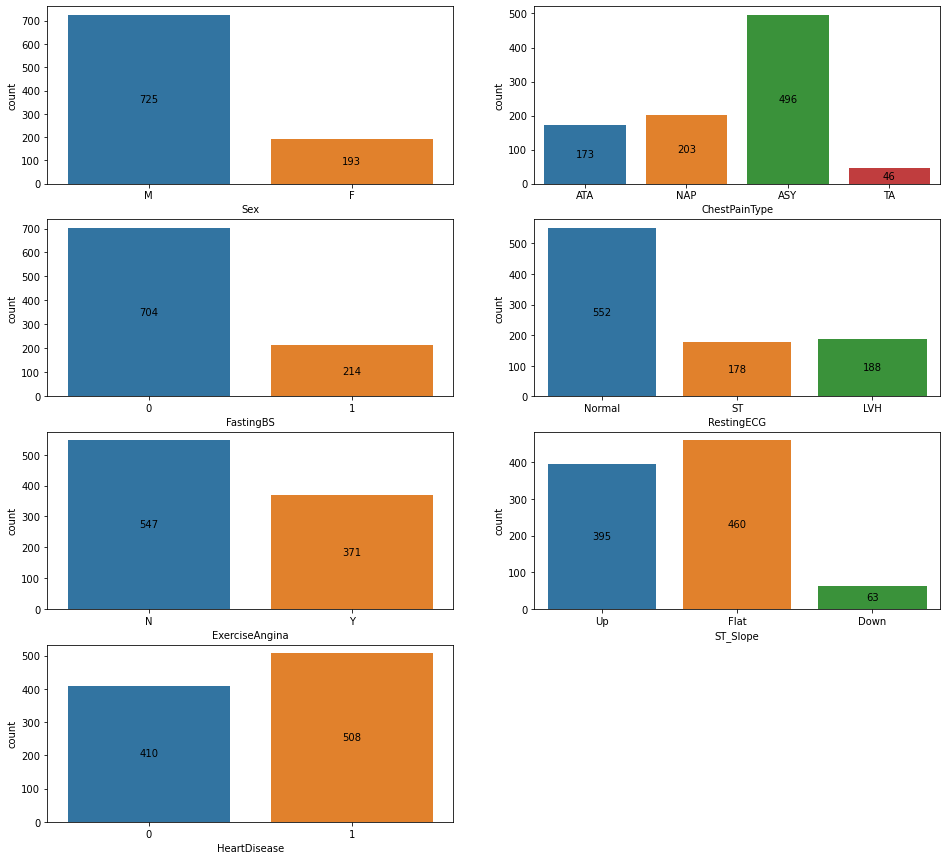

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']

fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical_cols):
    ax = plt.subplot(4, 2, idx+1)
    sns.countplot(x=data[col], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

The results can be summarized as follows:
- women are underrepresented in the dataset which may introduce bias and lead to unreliable results for prediction of female patients
- most patients have an asymptomatic chest pain type
- most patients show normal electrocardiogram results
- down slope for the peak exercise is underrepresented
- the occurence of heart diseases is well distributed in the dataset

More insights can be gained by grouping these categorical features with the `HeartDisease` target variable:

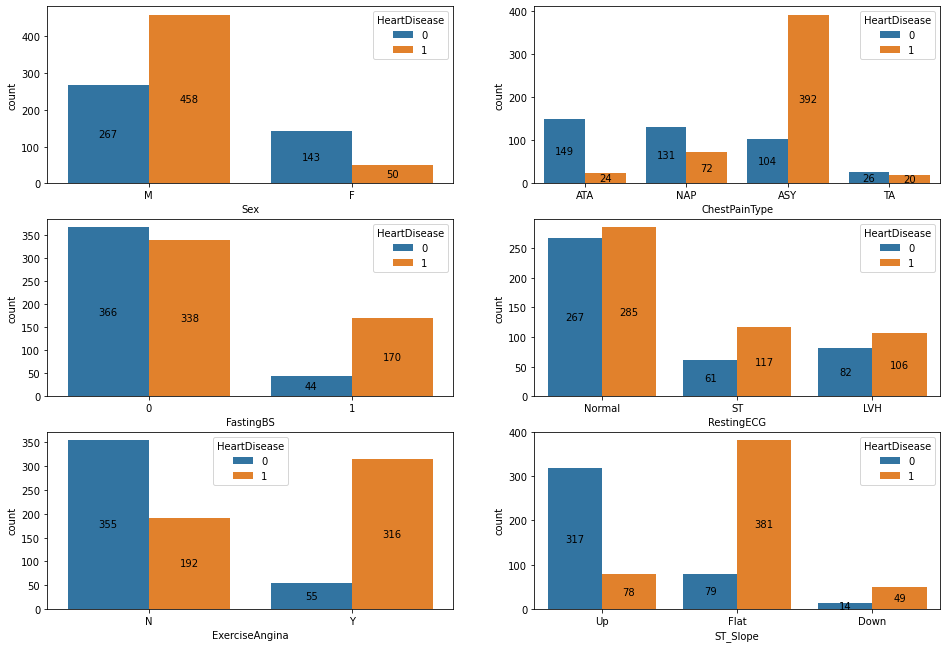

In [7]:
fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical_cols[:-1]):
    ax = plt.subplot(4, 2, idx+1)
    # group by HeartDisease
    sns.countplot(x=data[col], hue=data["HeartDisease"], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

The findings can be described as follows:
- men seem to be more prone to heart disease than women
- a significant count of patients with heart disease have asymptomatic chest pain (ASY)
- a significant number of patients with heart disease has high fasting blood sugar
- the correlation of electrocardiogram results seem to be low
- up and flat ST Slope seem to be correlated significantly to heart disease

Based on these findings there should be appropriate features to predict heart disease. More insight will be gained in the chapter of Feature Selection. 

## Data Cleaning

As described above the features `RestingBP` and `Cholersterol` have minimum values of 0.0 which points to erroneous data. The occurence of these values is now calculated and assessed:

In [8]:
sum(data['RestingBP'] == 0)

1

In [9]:
sum(data['Cholesterol'] == 0)

172

There is `1` observation that has a resting blood pressure of 0 mm Hg. This observation can be deleted safely without influencing prediction quality negatively:

In [10]:
data_cleaned = data.copy()

data_cleaned = data_cleaned[data_cleaned['RestingBP'] != 0]

`172` observations have a value of 0 mm/dl for the `Cholesterol` feature. Since deletion of these observations would result in an inappropriate loss of data the missing values are replaced by substitutes instead. Herefore the median of the `Cholesterol` feature grouped by the `HeartDisease` feature is chosen (e.g.: all `Cholesterol == 0` values of observations with `HeartDisease == 0` are replaced by the median of all `Cholesterol` observations with `HeartDisease == 0`):

In [11]:
cholesterol_heartdisease = data_cleaned['Cholesterol'].groupby(data_cleaned['HeartDisease']).median()

NoCholesterolNoHeartDiseaseMask = (data_cleaned['Cholesterol'] == 0) & (data_cleaned['HeartDisease'] == 0)
data_cleaned.loc[NoCholesterolNoHeartDiseaseMask,'Cholesterol'] = cholesterol_heartdisease.iloc[0]

NoCholesterolHeartDiseaseMask = (data_cleaned['Cholesterol'] == 0) & (data_cleaned['HeartDisease'] == 1)
data_cleaned.loc[NoCholesterolHeartDiseaseMask,'Cholesterol'] = cholesterol_heartdisease.iloc[1]

As shown below the zero values were replaced succesfully:

In [12]:
data_cleaned.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000
mean,53.509269,132.540894,239.700109,0.233370,136.789531,0.886696,0.552890
std,9.437636,17.999749,54.352727,0.423206,25.467129,1.066960,0.497466
min,28.000000,80.000000,85.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,214.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,225.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


## Feature Selection

First all categorical features are one-hot encoded:

In [13]:
data = pd.get_dummies(data)

Now, a Pearson's correlation heat map is generated:

<AxesSubplot:>

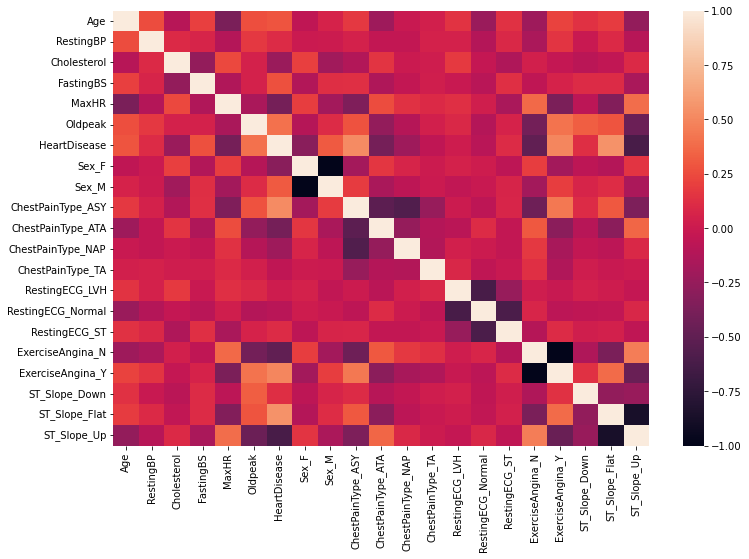

In [14]:
pearsons = data.corr()
plt.figure(figsize=(12,8))
sns.heatmap(pearsons)

By visually inspecting the plot above an absolute correlation threshold of `0.3` is defined to refine the plot:

<AxesSubplot:>

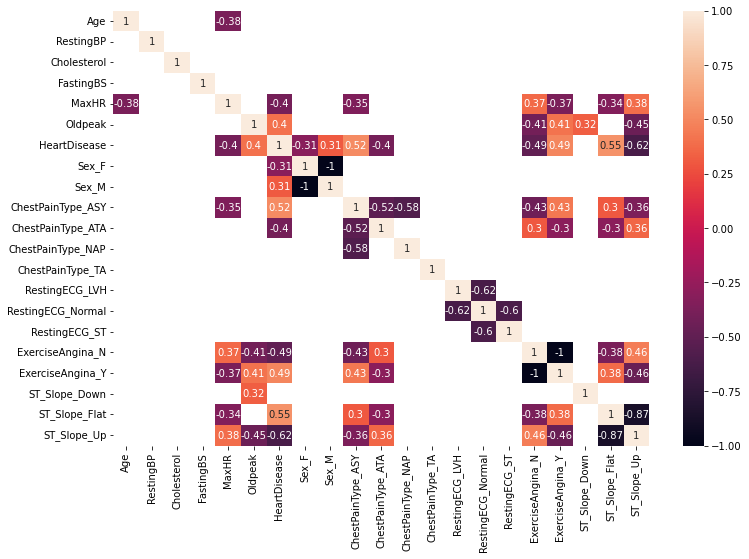

In [15]:
plt.figure(figsize=(12,8))
sns.heatmap(pearsons[abs(pearsons) > 0.3],annot=True)

The following features show reasonable correlation with `HeartDisease`:
- MaxHR
- Oldpeak
- Sex_F
- Sex_M
- ChestPainType_ASY
- ChestPainType_ATA
- ExerciseAngina_N
- ExerciseAngina_Y
- ST_Slope_Flat
- ST_Slope_Up

and are chosen in the next chapter for building the classifier.

## Building a Classifier

Based on the selected features various k-nearest-neighbors classifiers are trained. First a classifier is trained for each single feature. Then a classifier is trained based on all features simutaneously and compared to the classifiers mentioned before.

First the dataset is split into training (60%), test and validation sets (20% each):

In [16]:
from sklearn.model_selection import train_test_split

X = data.drop(columns = 'HeartDisease')
y = data['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.25, random_state=42)

Now the classifiers are trainined and evaluated based on the selected features for `K = [1,2,...,20]`:

In [17]:
from sklearn.neighbors import KNeighborsClassifier

features = ['MaxHR','Oldpeak','Sex_F','Sex_M','ChestPainType_ASY','ChestPainType_ATA','ExerciseAngina_N','ExerciseAngina_Y','ST_Slope_Flat','ST_Slope_Up']
ks = range(1, 20)
accuracies = {}
best_ks = {}

for feature in features:
    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train[feature].values.reshape(-1,1),y_train)
        score = knn.score(X_val[feature].values.reshape(-1,1),y_val)
        
        if feature in accuracies:
            if score > accuracies[feature]:
                accuracies[feature] = score
                best_ks[feature] = k
        else:
            accuracies[feature] = score
            best_ks[feature] = k

for w in sorted(accuracies, key=accuracies.get, reverse=True):
    print(w, accuracies[w])
    
print(best_ks)

ST_Slope_Up 0.8641304347826086
ST_Slope_Flat 0.7934782608695652
Oldpeak 0.782608695652174
ExerciseAngina_N 0.782608695652174
ExerciseAngina_Y 0.782608695652174
ChestPainType_ASY 0.7663043478260869
MaxHR 0.7228260869565217
Sex_M 0.6684782608695652
Sex_F 0.42391304347826086
ChestPainType_ATA 0.42391304347826086
{'MaxHR': 16, 'Oldpeak': 5, 'Sex_F': 1, 'Sex_M': 19, 'ChestPainType_ASY': 9, 'ChestPainType_ATA': 1, 'ExerciseAngina_N': 1, 'ExerciseAngina_Y': 3, 'ST_Slope_Flat': 5, 'ST_Slope_Up': 5}


The model trained on the `ST_Slope_Up` feature performed best with `86.4 %` accuracy based on the validation dataset. `K` was found to be 5. Testing the model on the test set an accuracy of `79.9 %`is achieved:

In [18]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train['ST_Slope_Up'].values.reshape(-1,1),y_train)
score = knn.score(X_test['ST_Slope_Up'].values.reshape(-1,1),y_test)

print(score)

0.7989130434782609


---

Now a classifier is trained on all features simutaneously. To perform this task, the features have to be normalized first:

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])

ks = range(1, 20)
accuracies = {}

for k in ks:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_scaled,y_train)
    score = knn.score(X_val_scaled,y_val)
    accuracies[k] = score
        
for w in sorted(accuracies, key=accuracies.get, reverse=True):
    print(w, accuracies[w])        

6 0.8858695652173914
7 0.8858695652173914
17 0.8858695652173914
5 0.8804347826086957
8 0.8804347826086957
9 0.8804347826086957
14 0.8804347826086957
15 0.8804347826086957
16 0.8804347826086957
18 0.8804347826086957
19 0.8804347826086957
10 0.875
11 0.875
12 0.875
13 0.875
3 0.8478260869565217
4 0.8315217391304348
1 0.8152173913043478
2 0.7934782608695652


Including all selected features the accuracy could be improved slightly to `88.6 %`. During this process the hyperparameter `K` was found to be 6.

Testing the model on the test set an accuracy of `80.4 %` is achieved:

In [20]:
X_test_scaled = scaler.transform(X_test[features])

knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(X_train_scaled,y_train)
score = knn.score(X_test_scaled,y_test)

print(score)

0.8043478260869565


---

In the following the parameter `metric` shall be taken into account in a more comprehensible hyperparameter optimization:

In [21]:
from sklearn.model_selection import GridSearchCV

# GridSearchCV creates a validation set as part of its process so the splitting is updated
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])

grid_params = {'n_neighbors': range(1, 20),
                'metric': ['minkowski', 'manhattan', 'cityblock', 'cosine']
              }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring = 'accuracy')
knn_grid.fit(X_train_scaled, y_train)

best_score = knn_grid.best_score_
best_params = knn_grid.best_params_

print(f"Best model's accuracy: {best_score*100:.2f}")
print(f"Best model's parameters: {best_params}")

Best model's accuracy: 85.28
Best model's parameters: {'metric': 'manhattan', 'n_neighbors': 17}


Optimizing the hyperparameters `K` and `metric` simultaneously an accuracy on the validation set of `85.3 %` could be achieved. This result is inferior to the result of the single feature classifier `ST_Slope_Up` shown above. However, `GridSearchCV` usually predicts accuracy on the test set better by cross validating the validation set. This is shown in the following:

In [22]:
X_test_scaled = scaler.transform(X_test[features])

accuracy = knn_grid.best_estimator_.score(X_test_scaled, y_test)
print(f" Model Accuracy on test set: {accuracy*100:.2f}")

 Model Accuracy on test set: 82.61


## Summary

A k-nearest-neighbors classifier was trained on the selected features:
- MaxHR
- Oldpeak
- Sex_F
- Sex_M
- ChestPainType_ASY
- ChestPainType_ATA
- ExerciseAngina_N
- ExerciseAngina_Y
- ST_Slope_Flat
- ST_Slope_Up

and could yield an accuracy of `82.6 %` based on the hyperparameters `metric = manhattan` and `K = 17`. 